# Revenue Optimization through pricing micro-challenge

In [1]:
import numpy as np
from tqdm import tqdm
from IPython.display import display, Javascript
import json
from collections import namedtuple
from numpy.random import uniform, seed
from numpy import floor

## Helpers functions

In [2]:
def _tickets_sold(p, demand_level, max_qty):
    quantity_demanded = floor(max(0, p - demand_level))
    return min(quantity_demanded, max_qty)

In [85]:
# Simulate revenues achieved by pricing function on a event (days_left before event, number of tickets to sell) with random demand

def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200, verbose=False):
    
    if (days_left == 0) or (tickets_left == 0):
        
        if verbose:
            if (days_left == 0):
                print("The flight took off today. ")
            if (tickets_left == 0):
                print("This flight is booked full.")
            print("Total Revenue: €{:.0f}".format(rev_to_date))
        return rev_to_date
    
    else:
        
        demand_level = uniform(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(demand_level, p, tickets_left)
        
        if verbose:
            print("{:.0f} days before flight: "
                  "Started with {:.0f} seats. "
                  "Demand level: {:.0f}. "
                  "Price set to €{:.0f}. "
                  "Sold {:.0f} tickets. "
                  "Daily revenue is {:.0f}. Total revenue-to-date is {:.0f}. "
                  "{:.0f} seats remaining".format(days_left, tickets_left, demand_level, p, q, p*q, p*q+rev_to_date, tickets_left-q))
        return simulate_revenue(days_left = days_left-1,
                              tickets_left = tickets_left-q,
                              pricing_function=pricing_function,
                              rev_to_date=rev_to_date + p * q,
                              demand_level_min=demand_level_min,
                              demand_level_max=demand_level_max,
                              verbose=verbose)

In [86]:
# Calculate average revenues per event achieved by pricing function on a range of events => To compare algorithms

def score_me(pricing_function, sims_per_scenario=200):
    
    seed(0)
    Scenario = namedtuple('Scenario', 'n_days n_tickets')
    scenarios = [Scenario(n_days=100, n_tickets=100), Scenario(n_days=14, n_tickets=50),
                 Scenario(n_days=2, n_tickets=20), Scenario(n_days=1, n_tickets=3),
                 ]
    scenario_scores = []
    
    for s in scenarios:
        
        scenario_score = sum(simulate_revenue(s.n_days, s.n_tickets, pricing_function)
                                     for _ in range(sims_per_scenario)) / sims_per_scenario
        
        print("Ran {:.0f} flights starting {:.0f} days before flight with {:.0f} tickets. "
              "Average revenue: €{:.0f}".format(sims_per_scenario, s.n_days, s.n_tickets, scenario_score))
        
        scenario_scores.append(scenario_score)
    
    score = sum(scenario_scores) / len(scenario_scores)
    
    print("Average revenue across all flights is €{:.0f}".format(score))

# Testing a pricing function

In [87]:
# in command line
# %conda install jupyterthemes ## --user git+https://github.com/dunovank/jupyter-themes.git
#jt -t grade3 -fs 115 -altp -tfs 13 -nfs 115 -ofs 11 -cellw 88% -T
# to retore to jupyter notebook defaults, type: jt -r

In [88]:
def basic_pricing_function(days_left, tickets_left, demand_level):
    """Sample pricing function"""
    price = demand_level - 10
    return price

In [89]:
simulate_revenue(days_left=7, tickets_left=50, pricing_function=basic_pricing_function, verbose=True)
print()

7 days before flight: Started with 50 seats. Demand level: 124. Price set to €114. Sold 10 tickets. Daily revenue is 1142. Total revenue-to-date is 1142. 40 seats remaining
6 days before flight: Started with 40 seats. Demand level: 146. Price set to €136. Sold 10 tickets. Daily revenue is 1363. Total revenue-to-date is 2505. 30 seats remaining
5 days before flight: Started with 30 seats. Demand level: 113. Price set to €103. Sold 10 tickets. Daily revenue is 1026. Total revenue-to-date is 3531. 20 seats remaining
4 days before flight: Started with 20 seats. Demand level: 114. Price set to €104. Sold 10 tickets. Daily revenue is 1042. Total revenue-to-date is 4574. 10 seats remaining
3 days before flight: Started with 10 seats. Demand level: 169. Price set to €159. Sold 10 tickets. Daily revenue is 1586. Total revenue-to-date is 6159. 0 seats remaining
This flight is booked full.
Total Revenue: €6159



## Optimization algorithm
- Examples of pricing functions using very simple approaches

In [71]:
# Sell tickets at the price optimizing revenues, ie p* = demand / 2  # We know this is highly sub-optimal
def pricing_function0(days_left, tickets_left, demand_level):
    # Sell all tickets left on last day
    if days_left == 1 :
        price = demand_level - tickets_left
    else:
        price = min (demand_level/2, demand_level - tickets_left)

    return price

In [72]:
# simple approach where we sell tickets only if demand is high enough allowing for higher prices
def pricing_function1(days_left, tickets_left, demand_level):
    # Sell all tickets left on last day
    if days_left == 1 :
        price = demand_level - tickets_left
    else:
        if demand_level < 175:
            price = demand_level  # sell no ticket if demand below 175
        else:
            price = min (200 - tickets_left, demand_level - tickets_left/2)  # if demand is 175 or higher, sell no more than half of the tickets left to allow further optimization
            
    return price

In [73]:
# approach where we sell a amount of tickets proportional to the likelyhood to get higher demand and the number of days left
def pricing_function2(days_left, tickets_left, demand_level):
    # Sell all tickets left on last day
    if days_left == 1 :
        price = demand_level - tickets_left
    else:
        if days_left > 4:
            sell = min(tickets_left, tickets_left / days_left * 1 / ((200 - demand_level)/ 100) )
            price = max(0,200 - sell)
        else:
            sell = min(tickets_left, tickets_left / days_left * 1 / ((200 - demand_level)/ 100) )
            price = max(0,demand_level - sell)
        
    return price

In [74]:
# Segment further to take opportunity of higher demand levels
def pricing_function3(days_left, tickets_left, demand_level):
    # Sell all tickets left on last day
    if days_left == 1 :
        price = demand_level - tickets_left
    else:
        if days_left > 3:
            price = 200 - tickets_left/2
        elif days_left <= 3:
            price = 175 - tickets_left/2
        else:
            price = 150 - tickets_left
    return price

In [75]:
# sell small amount of tickets only and only if demand is above 170 
def pricing_function4(days_left, tickets_left, demand_level):
    # Sell all tickets left on last day
    if days_left == 1 :
        price = demand_level - tickets_left
    else:
        if demand_level < 170:
            price = demand_level
        else:
            price = demand_level-10

    return price

In [76]:
# sell only if demand is above 173 and sell a number of tickets decreasing with the number of days left
def pricing_function5(days_left, tickets_left, demand_level):

    # Sell all tickets left on last day
    if days_left == 1:
        price = demand_level - tickets_left
    # Sell 10% of the tickets left on the second last day if demand is above average
    elif days_left == 2 and demand_level > 150:
        price = 0.9*demand_level
    # Only sell tickets if demand is higher than 173
    elif demand_level > 173:
        price = demand_level - (tickets_left - days_left)/2
    else:
        price = demand_level # sell no tickets
    return price

In [90]:
for index, f in enumerate([pricing_function0, pricing_function1, pricing_function2, pricing_function3, pricing_function4, pricing_function5]):
    print('\npricing function {} :'.format(index))
    score_me(f, 200)


pricing function 0 :
Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: €5004
Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: €3728
Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: €1503
Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: €434
Average revenue across all flights is €2667

pricing function 1 :
Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: €10997
Ran 200 flights starting 14 days before flight with 50 tickets. Average revenue: €7681
Ran 200 flights starting 2 days before flight with 20 tickets. Average revenue: €2729
Ran 200 flights starting 1 days before flight with 3 tickets. Average revenue: €431
Average revenue across all flights is €5459

pricing function 2 :
Ran 200 flights starting 100 days before flight with 100 tickets. Average revenue: €14612
Ran 200 flights starting 14 days before flight with 50 tickets.

Conclusion: we can observe that selling a maximum of tickets at the optimal theoritical price gets the worste result (function 0). The more we segment the better. Selling smaller quantities in the early stages to maximize opportunities to sell at higher prices as well.

Let's now try more elaborate approaches.

- Optimization algorithms. Brute Force

In [106]:
# let's define containers for brute force calculation of optimum prices
# we assume max day left = 100, max tickets to sell = 100
n = 100
optimal_prices = np.zeros((n+1, n+1, n+1), dtype='uint8') # The optimal price given the number of days left (0->100), tickets left (0->100) and current demand level (100->200)
optimal_sales = np.zeros((n+1, n+1), dtype=np.float)      # Expected profit when pricing optimally given the number of days and tickets left

# Base case when there is 1 day left
for tickets_left in range(n+1):
    
    for demand in range(n, 2*n+1):
        
        tickets_sold = min(demand // 2, tickets_left) # demand / 2 is the optimal quantity to sell if there are enough tickets left
        price = demand - tickets_sold
        
        optimal_prices[1, tickets_left, demand - 100] = price
        
        # Calculate optimal revenue expectation. Sum over every demand level with equal chance of occurence (uniform distribution)
        optimal_sales[1, tickets_left] += (price * tickets_sold / 101) # Average out the best profit through all possible demand levels
        
# Fill in the tables
for days_left in tqdm(range(2, n+1)):
    
    for tickets_left in range(n+1):
        
        last_best_price = 0 # For previous demand level (one lower)
        
        for demand in range(n, 2*n+1):
            
            # Search over all prices to find the best price for the context: days_left, tickets_left, demand_level
            best_revenue = 0
            best_price = 0
                        
            # No need to search all prices in range(0, demand):
            for price in range(max(demand - tickets_left, last_best_price), demand+1): # optimal price should not be lower than demand - remaining tickets or the last best price
                
                tickets_sold = min(demand - price, tickets_left) # This is the quantity that will be sold at price p
                revenue = price * tickets_sold + optimal_sales[days_left - 1, tickets_left - tickets_sold] # This is the total expected profit if selling at price p
                
                if revenue > best_revenue: # Update best profit and price
                    best_revenue, best_price = revenue, price
            
            # Set the optimal price and profit values
            optimal_prices[days_left, tickets_left, demand-100] = best_price
            
            # similarly let's calculate the optimal_sales expectation over all possible demand level (same probability of occurence)
            optimal_sales[days_left, tickets_left] += (best_revenue / 101) # Average out the best profit through all possible demand level
            
            last_best_price = best_price # For higher demand levels, this best_price is the floor

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:06<00:00, 15.97it/s]


In [149]:
def pricing_function_6(days_left, tickets_left, demand_level):
    """Return the optimal price"""
    
    # These should be cast to an integer (and rounded down)
    tickets_left = int(tickets_left)
    demand_level = int(demand_level)
    
    return optimal_prices[days_left, tickets_left, demand_level-100] # Return the precomputed values

In [150]:
print('pricing function:')

simulate_revenue(days_left=7, tickets_left=50, pricing_function=pricing_function_6, verbose=True)
score_me(pricing_function_6, 200)

pricing function:
7 days before flight: Started with 50 seats. Demand level: 198. Price set to €175. Sold 23 tickets. Daily revenue is 4025. Total revenue-to-date is 4025. 27 seats remaining
6 days before flight: Started with 27 seats. Demand level: 152. Price set to €150. Sold 1 tickets. Daily revenue is 150. Total revenue-to-date is 4175. 26 seats remaining
5 days before flight: Started with 26 seats. Demand level: 149. Price set to €146. Sold 2 tickets. Daily revenue is 292. Total revenue-to-date is 4467. 24 seats remaining
4 days before flight: Started with 24 seats. Demand level: 160. Price set to €152. Sold 7 tickets. Daily revenue is 1064. Total revenue-to-date is 5531. 17 seats remaining
3 days before flight: Started with 17 seats. Demand level: 109. Price set to €109. Sold 0 tickets. Daily revenue is 0. Total revenue-to-date is 5531. 17 seats remaining
2 days before flight: Started with 17 seats. Demand level: 131. Price set to €126. Sold 4 tickets. Daily revenue is 504. Total

# Let's finally use a Dynamic programming version
- taken from [here](https://www.kaggle.com/aliaksei0/airline-price-optimization-micro-challenge)

In [113]:
from math import floor

savedF = {}
savedG = {}                                  

def getF(tickets,days):
    if tickets<=0 or days <= 0:
        return 0
    if (tickets,days) in savedF:
        return savedF[(tickets,days)]
    res = 0.0
    #count math expectation 
    for i in range(100, 201):
        res += getG(tickets, days, i)[0]
    res /= 101
    
    savedF[(tickets,days)] = res
    return res

def getG(tickets, days, demand):
    if days <= 0 or tickets <= 0:
        return (0,0)
    if (tickets, days, demand) in savedG:
        return savedG[(tickets, days, demand)]
    topTotal = -1
    topPrice = -1
    for i in range(1, demand+1):
        res = min(demand-i, tickets)*i + (getF(tickets-(demand-i), days-1) if tickets-(demand-i) > 0 else 0)
        if res > topTotal:
            topTotal, topPrice = res, i
    savedG[(tickets, days, demand)] = (topTotal, topPrice)
    return (topTotal, topPrice)

In [147]:
def pricing_function_7(days_left, tickets_left, demand_level):
    demand_level_floor = int(floor(demand_level))
    demand_delta = demand_level - demand_level_floor
    (topTotal, topPrice) = getG(tickets_left, days_left, demand_level_floor)
    return topPrice + demand_delta - 0.00001

In [148]:
print('pricing function:')
simulate_revenue(days_left=7, tickets_left=50, pricing_function=pricing_function_7, verbose=True)
score_me(pricing_function_7, 200)

pricing function:
7 days before flight: Started with 50 seats. Demand level: 198. Price set to €175. Sold 23 tickets. Daily revenue is 4028. Total revenue-to-date is 4028. 27 seats remaining
6 days before flight: Started with 27 seats. Demand level: 152. Price set to €151. Sold 1 tickets. Daily revenue is 151. Total revenue-to-date is 4179. 26 seats remaining
5 days before flight: Started with 26 seats. Demand level: 149. Price set to €147. Sold 2 tickets. Daily revenue is 293. Total revenue-to-date is 4472. 24 seats remaining
4 days before flight: Started with 24 seats. Demand level: 160. Price set to €153. Sold 7 tickets. Daily revenue is 1068. Total revenue-to-date is 5540. 17 seats remaining
3 days before flight: Started with 17 seats. Demand level: 109. Price set to €109. Sold 0 tickets. Daily revenue is 0. Total revenue-to-date is 5540. 17 seats remaining
2 days before flight: Started with 17 seats. Demand level: 131. Price set to €127. Sold 4 tickets. Daily revenue is 507. Total

# Appendix: Revenue curve illustrations

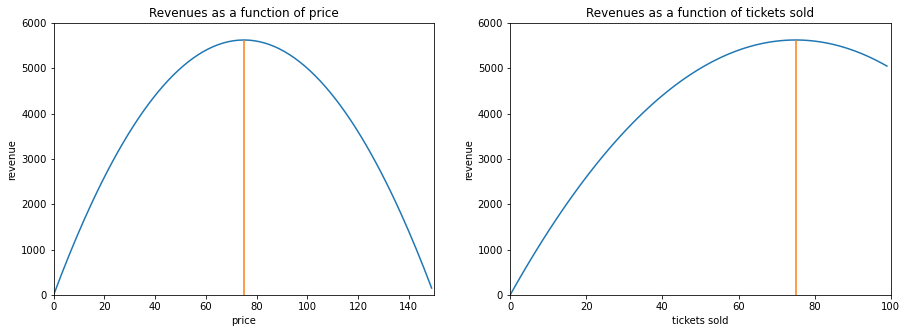

In [146]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
x = np.arange(0, 150)
y = x * (150 - x)
plt.ylim(0,6000)
plt.xlim(0,150)
plt.plot(x,y)
plt.plot((75,75), (0,5600))
plt.title('Revenues as a function of price')
plt.xlabel('price')
plt.ylabel('revenue')

plt.subplot(1,2,2)
x = np.arange(0, 100)
y = x * (150 - x)
plt.ylim(0,6000)
plt.xlim(0,100)
plt.plot(x,y)
plt.plot((75,75), (0,5600))
plt.title('Revenues as a function of tickets sold')
plt.xlabel('tickets sold')
plt.ylabel('revenue')

plt.savefig('revenue_curve.png')
plt.show()